```{contents}
```

## Hyperparameters Tuning

### 1. **max\_depth**

* Controls how deep the tree can grow.
* **Small depth** → underfitting (too simple).
* **Large depth** → overfitting (memorizes training data).
* 🔑 Tip: Tune using cross-validation. Typical values = `3–15`.

---

### 2. **min\_samples\_split**

* Minimum number of samples required to split an internal node.
* Prevents splitting when not enough data supports it.
* Higher values = more conservative trees.

---

### 3. **min\_samples\_leaf**

* Minimum samples required in a leaf node.
* Ensures leaves have enough data (prevents tiny, noisy leaves).
* Often set between `1–5%` of dataset size.

---

### 4. **max\_features**

* Number of features to consider when looking for the best split.
* Options:

  * `"sqrt"` (good for classification)
  * `"log2"`
  * `None` (use all features)
* Helps reduce variance & speed up training.

---

### 5. **criterion**

* Metric used to measure quality of split.

  * `"gini"` (default, faster).
  * `"entropy"` (uses log, more computationally heavy).
* Both usually give similar results.

---

### 6. **max\_leaf\_nodes**

* Restricts the number of leaf nodes.
* Controls complexity similar to `max_depth`.

---

### 7. **class\_weight**

* Adjusts weight for imbalanced datasets.
* `"balanced"` makes class weights inversely proportional to class frequencies.

---

### 8. **ccp\_alpha (Cost Complexity Pruning)**

* Controls pruning (removing branches that don’t improve performance).
* Higher values prune more → simpler tree.

---

## ⚖️ How to Tune These?

1. **Manual Grid Search** → Try combinations of hyperparameters.
2. **Randomized Search CV** → Faster, samples random combinations.
3. **Bayesian Optimization / AutoML** → Advanced approaches (e.g., Optuna, Hyperopt).

---

## 🎯 Typical Workflow

1. Start with a baseline model (`DecisionTreeClassifier()` default).
2. Use **cross-validation** with `GridSearchCV` or `RandomizedSearchCV`.
3. Tune: `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`.
4. Apply pruning (`ccp_alpha`).
5. Evaluate with metrics (Accuracy, F1, ROC-AUC depending on dataset balance).

---

👉 In short:

* If your tree is **too complex**, control it with `max_depth`, `min_samples_leaf`, or pruning.
* If it’s **too simple**, reduce constraints.
* Use cross-validation to find the **sweet spot**.



In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
iris = load_iris()
X, y = iris.data, iris.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Base model
dtc = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best model
best_dtc = grid_search.best_estimator_

# Predictions
y_pred = best_dtc.predict(X_test)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=iris.target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.9333333333333333

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Confusion Matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


## Pruning 

* A **Decision Tree grows until all leaves are pure** (or meet stopping criteria).
* This often leads to a very **deep and complex tree** → memorizes training data (overfitting).
* **Pruning = cutting back branches** that don’t contribute much to predictive power.

👉 Think of pruning like trimming a plant 🌿: keep only the strong, useful branches.

---

### 🛠️ Types of Pruning

#### 1. **Pre-Pruning (Early Stopping)**

* Stop tree growth **before** it becomes too complex.
* Controlled by hyperparameters:

  * `max_depth` → limit depth.
  * `min_samples_split` → minimum samples to split a node.
  * `min_samples_leaf` → minimum samples per leaf.
  * `max_leaf_nodes` → limit total leaves.
* ⚡ Faster but may underfit if you stop too early.

---

#### 2. **Post-Pruning (Cost Complexity Pruning)**

* Let the tree grow fully, then **remove unnecessary branches**.

* Based on **Cost Complexity Pruning** (a.k.a. **Minimal Cost-Complexity Pruning**):

  * Each subtree has a cost:

    $$
    R_\alpha(T) = R(T) + \alpha \cdot |T|
    $$

    where:

    * $R(T)$ = impurity/error of the tree
    * $|T|$ = number of leaves (complexity)
    * $\alpha$ = complexity penalty parameter

* Larger $\alpha$ → more pruning → simpler tree.


---

#### When to Use Which

* **Pre-pruning** → if dataset is very large, to save time.
* **Post-pruning** → if you want a tree to grow fully, then simplify it optimally.
* In practice: **use cost-complexity pruning (`ccp_alpha`)** along with some pre-pruning limits.

---

**Summary**:

* **Pruning = reduce tree size to avoid overfitting**.
* **Pre-pruning** stops early with hyperparameters.
* **Post-pruning** uses **ccp\_alpha** to cut weak branches after training.
* Pruned trees generalize better on unseen data.


Unpruned Tree → Train Acc: 1.000, Test Acc: 1.000


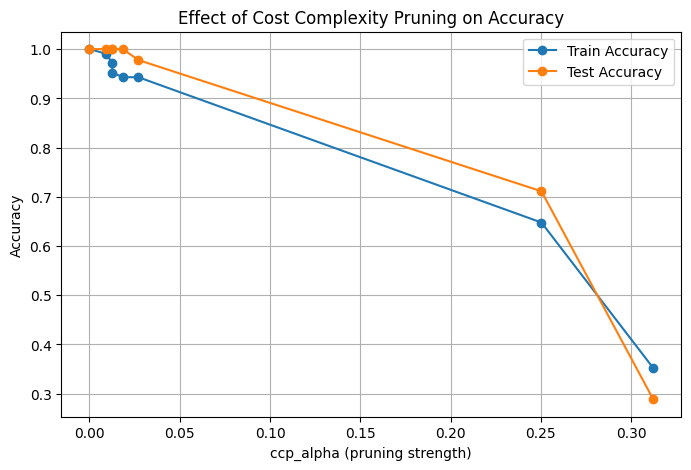

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 1. Load dataset
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Train an unpruned decision tree (overfitting possible)
dt_unpruned = DecisionTreeClassifier(random_state=42)
dt_unpruned.fit(X_train, y_train)

train_acc_unpruned = accuracy_score(y_train, dt_unpruned.predict(X_train))
test_acc_unpruned = accuracy_score(y_test, dt_unpruned.predict(X_test))

print(f"Unpruned Tree → Train Acc: {train_acc_unpruned:.3f}, Test Acc: {test_acc_unpruned:.3f}")

# 3. Get effective alphas for pruning
path = dt_unpruned.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# 4. Train trees for different alphas
train_scores, test_scores = [], []

for alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    dt.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, dt.predict(X_train)))
    test_scores.append(accuracy_score(y_test, dt.predict(X_test)))

# 5. Plot accuracy vs alpha
plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, train_scores, marker='o', label="Train Accuracy")
plt.plot(ccp_alphas, test_scores, marker='o', label="Test Accuracy")
plt.xlabel("ccp_alpha (pruning strength)")
plt.ylabel("Accuracy")
plt.title("Effect of Cost Complexity Pruning on Accuracy")
plt.legend()
plt.grid(True)
plt.show()
